In [17]:
import pandas as pd
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import ROOT
import datetime
import mplhep as hep
plt.style.use([hep.style.CMS, hep.style.firamath])

zlumi=37193.


def getToyResults(toys_dir):

    rgx='mu([-+]?[0-9]*\.?[0-9]*)_nu([-+]?[0-9]*\.?[0-9]*)'
    data=[]
    for f in os.listdir(toys_dir):
        if not '.root' in f : continue

        #decode values
        mu,nu=re.findall(rgx,f)[0]
        mu=float(mu)
        nu=float(nu)  

        #read results of toys
        url=os.path.join(toys_dir,f)
        fIn=ROOT.TFile.Open(url)
        limit=fIn.Get('limit')
        try:
            for i in range(limit.GetEntriesFast()):
                limit.GetEntry(i)
                data.append( [mu,nu,limit.iToy,limit.r] )
        except:
            pass
        fIn.Close()
    
    df=pd.DataFrame(data,columns=['mu','nu','itoy','r'])
    return df



df_toys=getToyResults(toys_dir='/eos/user/p/psilva/data/ppszx/toys_03May2021/')
df_asimov=getToyResults(toys_dir='/eos/user/p/psilva/data/ppszx/toys_03May2021/asimov')

df_toys.head()

mu   nu  itoy         r
0  0.5  0.5     2  0.484284
1  0.5  0.5     3  0.505422
2  0.5  0.5     4  0.521154
3  0.5  0.5     5  0.472617
4  0.5  0.5     6  0.624473

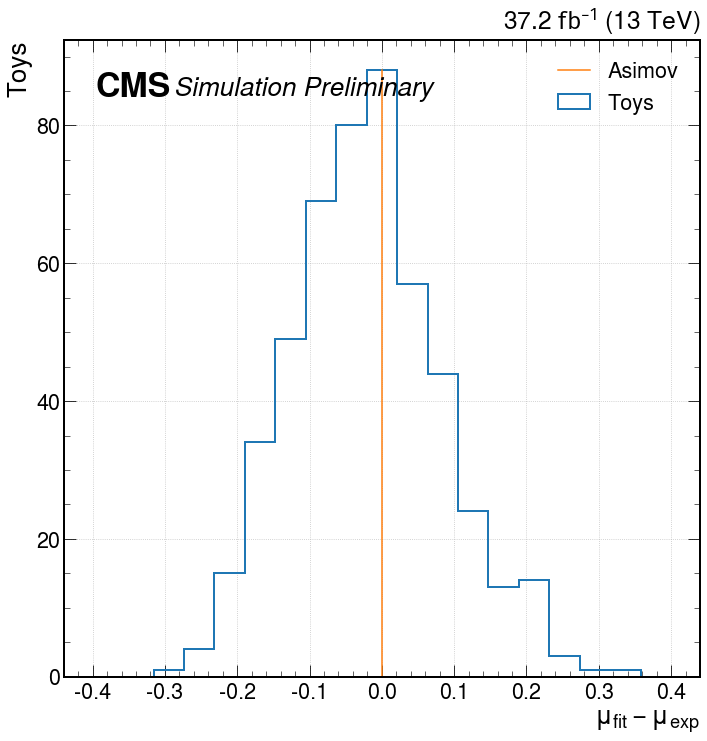

In [34]:
#show the distribution of a toy
mu,nu=1,1
mask=(df_toys['mu']==mu) & (df_toys['nu']==nu)
h,_,_=plt.hist(df_toys[mask]['r']-df_toys[mask]['mu'],histtype='step',linewidth=2,bins=np.linspace(-0.4,0.4,20),label='Toys')
mask=(df_asimov['mu']==mu) & (df_asimov['nu']==nu)
bias_asimov=df_asimov[mask]['r'].iloc[0]-mu
plt.plot([bias_asimov,bias_asimov],[0,np.max(h)],label='Asimov')

plt.legend()
plt.tight_layout()
hep.rcParams.label.lumi = '%3.1f'%(1e-3*zlumi)
hep.cms.label(loc=1)
plt.xlabel(r'$\mu_{fit}-\mu_{exp}$')
plt.ylabel('Toys')
plt.grid()
plt.show()

In [35]:
def summarize(df):
    df['bias']=df['r']-df['mu']
    df_summary=df.groupby(['mu','nu'])['bias'].agg(['mean','median', 'std'])
    df_summary.reset_index(inplace=True)
    return df_summary

df_toys_summary=summarize(df_toys)
df_asimov_summary=summarize(df_asimov)
df_toys_summary.head()

mu   nu      mean    median       std
0  0.0  0.5 -0.011567 -0.014565  0.069636
1  0.0  2.0 -0.010392 -0.009099  0.071899
2  0.0  5.0 -0.011040 -0.008332  0.072980
3  0.5  0.5 -0.005567 -0.009966  0.082536
4  0.5  2.0 -0.002793  0.001681  0.083177

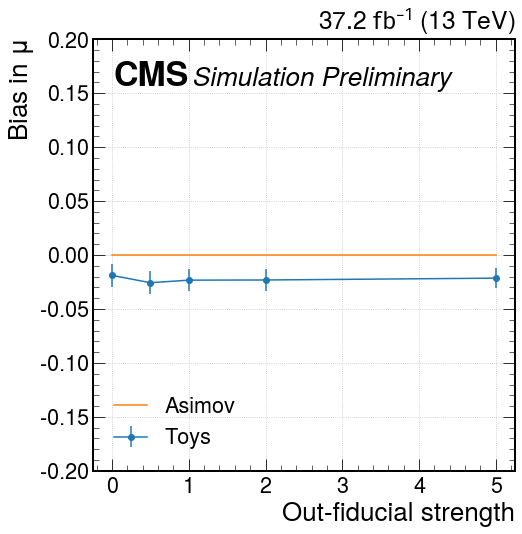

In [40]:
mu=1

fig,ax=plt.subplots(figsize=(8,8))

mask=(df_toys_summary['mu']==mu)
x=df_toys_summary[mask]['nu']
y=df_toys_summary[mask]['median']
yerr=df_toys_summary[mask]['std']/np.sqrt(100.)
plt.errorbar(x,y,yerr,label='Toys',marker='o')

mask=(df_asimov_summary['mu']==mu)
x=df_asimov_summary[mask]['nu']
y=df_asimov_summary[mask]['median']
plt.plot(x,y,label='Asimov')

plt.xlabel('Out-fiducial strength')
plt.ylabel(r'Bias in $\mu$')
hep.rcParams.label.lumi = '%3.1f'%(1e-3*zlumi)
hep.cms.label(loc=1)

plt.grid()
plt.legend(loc='lower left')
plt.tight_layout()
plt.ylim(-0.2,0.2)
plt.show()